In [1]:
import pandas as pd
import numpy as np
amzn_commerce_reviews_dataset = pd.read_csv('amazon-commerce-reviews.csv')
np.random.seed(923)

Sparsity of our Dataset

In [2]:
sparsity = 1 - (np.count_nonzero(amzn_commerce_reviews_dataset.iloc[:, 0:10000]) / amzn_commerce_reviews_dataset.iloc[:, 0:10000].size)
print(sparsity)

0.8527514666666667


Our data matrix is highly-sparse!!

20% of the Dataset is reserved as a validation data-set and the rest is the training dataset.

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(amzn_commerce_reviews_dataset.iloc[:, 0:10000],
                                                    amzn_commerce_reviews_dataset.iloc[:, 10000],
                                                    stratify=amzn_commerce_reviews_dataset.iloc[:, 10000],
                                                    test_size=0.2)

In [4]:
# Let's make sure we have a balanced training set.
print(y_train.value_counts())

Class
Calvinnme      24
Robert         24
Agresti        24
McKee          24
Shea           24
Wilson         24
Corn           24
Harp           24
Merritt        24
Hayes          24
Brown          24
Engineer       24
Morrison       24
Lovitt         24
Cutey          24
Lawyeraau      24
Blankenship    24
Grove          24
Mitchell       24
Auken          24
Comdet         24
Mahlers2nd     24
Peterson       24
Power          24
Bukowsky       24
Taylor         24
Ashbacher      24
Walters        24
CFH            24
Dent           24
Sherwin        24
Chell          24
Vision         24
Cholette       24
Kolln          24
Lee            24
Davisson       24
Janson         24
Johnson        24
Koenig         24
Chachra        24
Brody          24
Chandler       24
Goonan         24
Mark           24
Nigam          24
Messick        24
Vernon         24
Neal           24
Riley          24
Name: count, dtype: int64


We encode the labels of our classes so that they are mapped to {0, 1, ..., 49}

In [5]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
print(np.unique(y_train))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


Let's do some PCA!

In [6]:
# We must scale our datasets first to avoid having features of different magnitudes interfere
# with any dimensionality reduction methods or even the downstream classification models' performance
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1200)
X_train_scores_pca = pca.fit_transform(X_train)
X_test_scores_pca = pca.transform(X_test)

<ipython-input-71-c2d0bde3c2d0>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', 30))


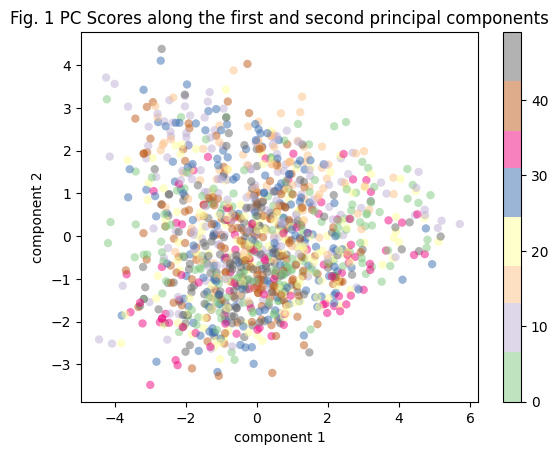

In [71]:
import matplotlib.pyplot as plt
plt.scatter(X_train_scores_pca[:, 0], X_train_scores_pca[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 30))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title("Fig. 1 PC Scores along the first and second principal components")
plt.colorbar();

Text(0.5, 1.0, 'Fig.2 Number of components vs Cumulative Explained Variance')

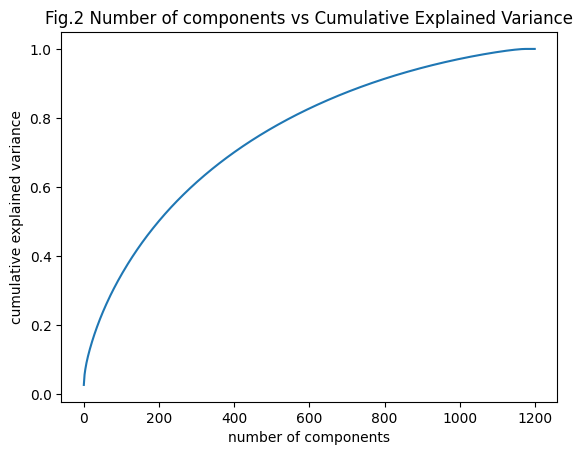

In [72]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title('Fig.2 Number of components vs Cumulative Explained Variance')

In [73]:
X_train_scores_pca = X_train_scores_pca[:, :600]
X_test_scores_pca = X_test_scores_pca[:, :600]

Let's do some Neighborhood Component Analysis (NCA)

In [10]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca = NeighborhoodComponentsAnalysis(random_state=923, n_components=10)
nca.fit(X_train, y_train)
X_train_scores_nca = nca.transform(X_train)
X_test_scores_nca = nca.transform(X_test)

<ipython-input-11-733f59813641>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('Accent', 30))


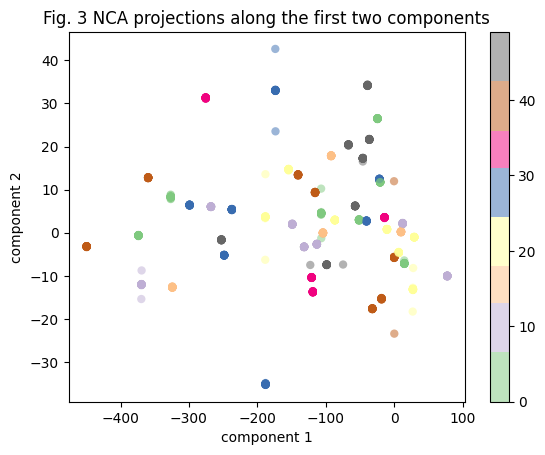

In [11]:
plt.scatter(X_train_scores_nca[:, 0], X_train_scores_nca[:, 1],
            c=y_train, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 30))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title("Fig. 3 NCA projections along the first two components")
plt.colorbar();

In [12]:
# However, we will fit NCA with 600 components for parity purposes with PCA
nca = NeighborhoodComponentsAnalysis(random_state=923, n_components=600)
nca.fit(X_train, y_train)
X_train_scores_nca = nca.transform(X_train)
X_test_scores_nca = nca.transform(X_test)

Chi-square test for independence

In [13]:
from sklearn.feature_selection import chi2
chi2_stats, p_values = chi2(X_train, y_train)

In [14]:
# calculate the number of statistically significant variables after applying the Bonferroni's correction
num_signficant_variables = sum(i <= (0.05 / 10000) for i in p_values)
print(num_signficant_variables)

303


In [15]:
statistically_significant_indices = np.argpartition(p_values, 303)[:303]
X_train_chi_square=X_train[:, statistically_significant_indices]
X_test_chi_square=X_test[:, statistically_significant_indices]

Method #1 Naive Bayes

In [16]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

In [74]:
# Let's first try fitting Multinomial_NBA on the unreduced dataset
# where we transform the training data set back into the integer counts
# since the multinomial NB works best with discrete features such as counts
multinomial_nb = MultinomialNB()
multinomial_nb_pca_scores = cross_val_score(multinomial_nb, scaler.inverse_transform(X_train), y_train, cv=5)
print(f'The average cross validation accuracy score is: {np.mean(multinomial_nb_pca_scores)}.')
print(f'The validation data score is: {multinomial_nb.fit(scaler.inverse_transform(X_train), y_train).score(scaler.inverse_transform(X_test), y_test)}.')

The average cross validation accuracy score is: 0.6966666666666667.
The validation data score is: 0.7166666666666667.


In [75]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

predictions = multinomial_nb.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = multinomial_nb.classes_)

In [76]:
# Only 6 out of 50 classes have an accuracy percentage of under 50% on the test set
print(sum(np.diagonal(cm) < 3))

6


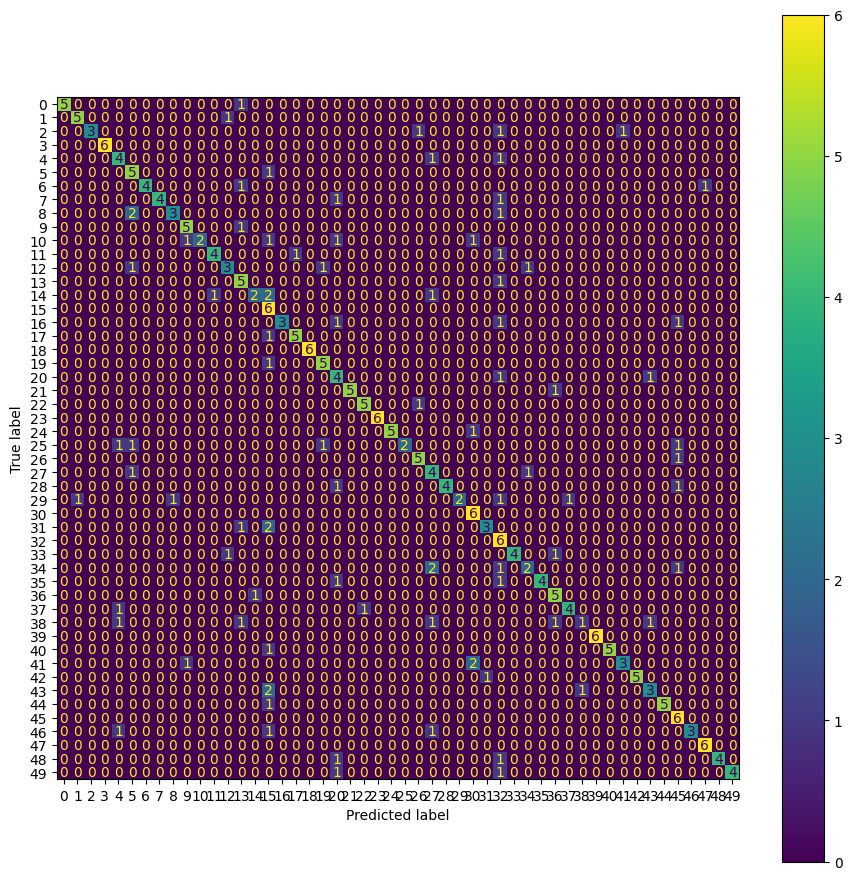

In [77]:
fig, ax = plt.subplots(figsize=(11, 11))
disp.plot(ax=ax)

In [78]:
# Now, let's try fitting GaussianNB on the PCA scores
gaussian_nb = GaussianNB()
gaussian_nb_pca_scores = cross_val_score(gaussian_nb, X_train_scores_pca, y_train, cv=5)
print(f'The average cross validation accuracy score is: {np.mean(gaussian_nb_pca_scores)}.')
print(f'The validation data score is: {gaussian_nb.fit(X_train_scores_pca, y_train).score(X_test_scores_pca, y_test)}.')

The average cross validation accuracy score is: 0.29583333333333334.
The validation data score is: 0.20666666666666667.


In [79]:
# Now, let's try fitting GaussianNB on the NCA projections
gaussian_nb = GaussianNB()
gaussian_nb_nca_scores = cross_val_score(gaussian_nb, X_train_scores_nca, y_train, cv=5)
print(f'The average cross validation accuracy score is: {np.mean(gaussian_nb_nca_scores)}.')
print(f'The validation data score is: {gaussian_nb.fit(X_train_scores_nca, y_train).score(X_test_scores_nca, y_test)}.')

The average cross validation accuracy score is: 0.7933333333333333.
The validation data score is: 0.56.


In [80]:
# Now, let's try fitting GaussianNB on the chi-square selected features
multinomial_nb = MultinomialNB()
multinomial_nb_chi_square_scores = cross_val_score(multinomial_nb, scaler.inverse_transform(X_train)[:, statistically_significant_indices], y_train, cv=5)
print(f'The average cross validation accuracy score is: {np.mean(multinomial_nb_chi_square_scores)}.')
print(f'The validation data score is: {multinomial_nb.fit(scaler.inverse_transform(X_train)[:,  statistically_significant_indices], y_train).score(scaler.inverse_transform(X_test)[:,  statistically_significant_indices], y_test)}.')

The average cross validation accuracy score is: 0.5358333333333334.
The validation data score is: 0.4866666666666667.


Method #2 K-Nearest Neighbors

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': [1, 2, 3, 5], 'weights': ['uniform', 'distance']}

In [82]:
# Let's try fitting k-nearest-neighbors using grid-search CV on PCA scores first
knn = KNeighborsClassifier()
grid_search_knn_pca = GridSearchCV(knn, params, cv=5)
grid_search_knn_pca.fit(X_train_scores_pca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5],
                         'weights': ['uniform', 'distance']})

In [83]:
print(grid_search_knn_pca.best_score_)
print(grid_search_knn_pca.best_params_)
grid_search_knn_pca.best_estimator_.score(X_test_scores_pca, y_test)

0.23916666666666667
{'n_neighbors': 1, 'weights': 'uniform'}


0.2

In [84]:
# Let's try fitting k-nearest-neighbors using grid-search CV on NCA projections
knn_nca = KNeighborsClassifier()
grid_search_knn_nca = GridSearchCV(knn_nca, params, cv=5)
grid_search_knn_nca.fit(X_train_scores_nca, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5],
                         'weights': ['uniform', 'distance']})

In [85]:
print(grid_search_knn_nca.best_score_)
print(grid_search_knn_nca.best_params_)
grid_search_knn_nca.best_estimator_.score(X_test_scores_nca, y_test)

0.8783333333333333
{'n_neighbors': 1, 'weights': 'uniform'}


0.5166666666666667

In [86]:
# Let's try fitting k-nearest-neighbors using grid-search CV on the chi-square selected variables
knn_chi_square = KNeighborsClassifier()
grid_search_chi_square = GridSearchCV(knn_chi_square, params, cv=5)
grid_search_chi_square.fit(X_train[:, statistically_significant_indices], y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5],
                         'weights': ['uniform', 'distance']})

In [87]:
print(grid_search_chi_square.best_score_)
print(grid_search_chi_square.best_params_)
grid_search_chi_square.best_estimator_.score(X_test[:, statistically_significant_indices], y_test)

0.37916666666666665
{'n_neighbors': 5, 'weights': 'distance'}


0.36

In [88]:
# Let's try fitting k-nearest-neighbors using grid-search CV on the original, scaled dataset
knn_original_scaled = KNeighborsClassifier()
grid_search_original_scaled = GridSearchCV(knn_original_scaled, params, cv=5)
grid_search_original_scaled.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 5],
                         'weights': ['uniform', 'distance']})

In [89]:
print(grid_search_original_scaled.best_score_)
print(grid_search_original_scaled.best_params_)
grid_search_original_scaled.best_estimator_.score(X_test, y_test)

0.15916666666666668
{'n_neighbors': 1, 'weights': 'uniform'}


0.17666666666666667

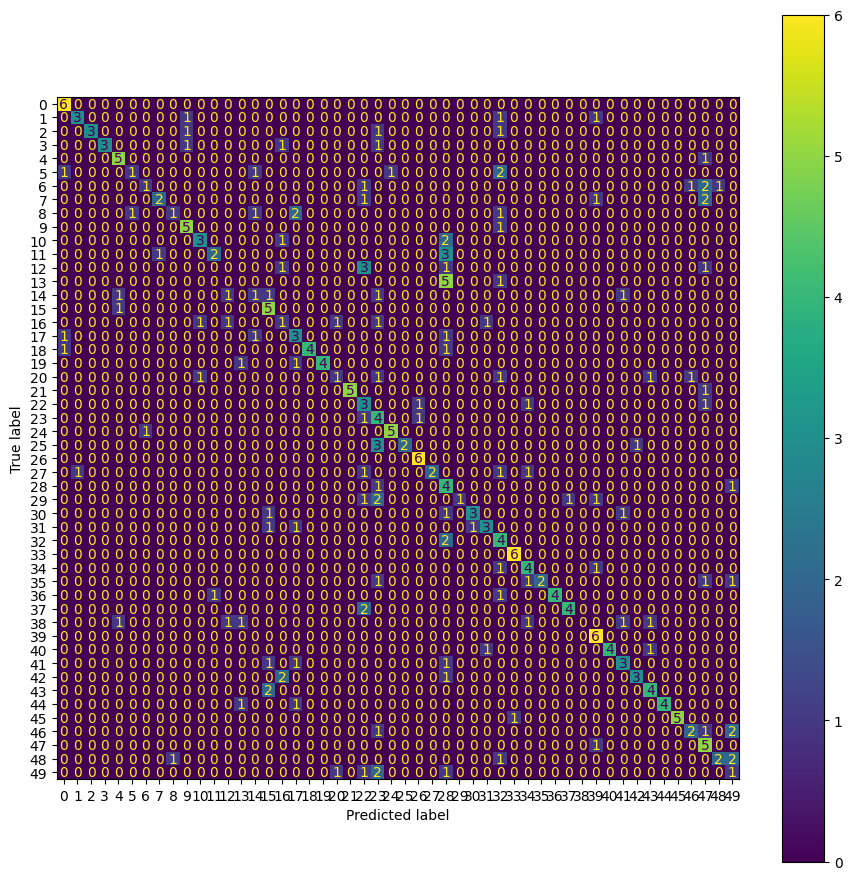

In [46]:
predictions = grid_search_knn_nca.best_estimator_.predict(X_test_scores_nca)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = grid_search_knn_nca.best_estimator_.classes_)
fig, ax = plt.subplots(figsize=(11, 11))
disp.plot(ax=ax)

In [47]:
# Approximately 18 out of 50 classes have an accuracy percentage of under 50% on the test set
print(sum(np.diagonal(cm) < 3))

18


Method #3 SVC

In [90]:
from sklearn.svm import SVC
params = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
          'gamma': ['scale', 'auto'] }

In [91]:
# Let's try fitting SVMS using grid-search CV on PCA scores first
svm = SVC()
grid_search_svm_pca = GridSearchCV(svm, params, cv=5)
grid_search_svm_pca.fit(X_train_scores_pca, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [92]:
print(grid_search_svm_pca.best_score_)
print(grid_search_svm_pca.best_params_)
grid_search_svm_pca.best_estimator_.score(X_test_scores_pca, y_test)

0.7224999999999999
{'gamma': 'scale', 'kernel': 'linear'}


0.7233333333333334

In [52]:
# Let's try fitting SVMS using grid-search CV on NCA projections
svm = SVC()
grid_search_svm_nca = GridSearchCV(svm, params, cv=5)
grid_search_svm_nca.fit(X_train_scores_nca, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [54]:
print(grid_search_svm_nca.best_score_)
print(grid_search_svm_nca.best_params_)
grid_search_svm_nca.best_estimator_.score(X_test_scores_nca, y_test)

0.9008333333333333
{'gamma': 'scale', 'kernel': 'linear'}


0.7266666666666667

In [55]:
# Let's try fitting SVMS using grid-search CV on the chi-square selected variables
svm = SVC()
grid_search_svm_chi_square = GridSearchCV(svm, params, cv=5)
grid_search_svm_chi_square.fit(X_train[:, statistically_significant_indices], y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [60]:
print(grid_search_svm_chi_square.best_score_)
print(grid_search_svm_chi_square.best_params_)
grid_search_svm_chi_square.best_estimator_.score(X_test[:, statistically_significant_indices], y_test)

0.5
{'gamma': 'scale', 'kernel': 'linear'}


0.47

In [61]:
# Let's try fitting SVMS using grid-search CV on all the features
svm = SVC()
grid_search_svm_original = GridSearchCV(svm, params, cv=5)
grid_search_svm_original.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [62]:
print(grid_search_svm_original.best_score_)
print(grid_search_svm_original.best_params_)
grid_search_svm_original.best_estimator_.score(X_test, y_test)

0.7108333333333334
{'gamma': 'scale', 'kernel': 'linear'}


0.7433333333333333

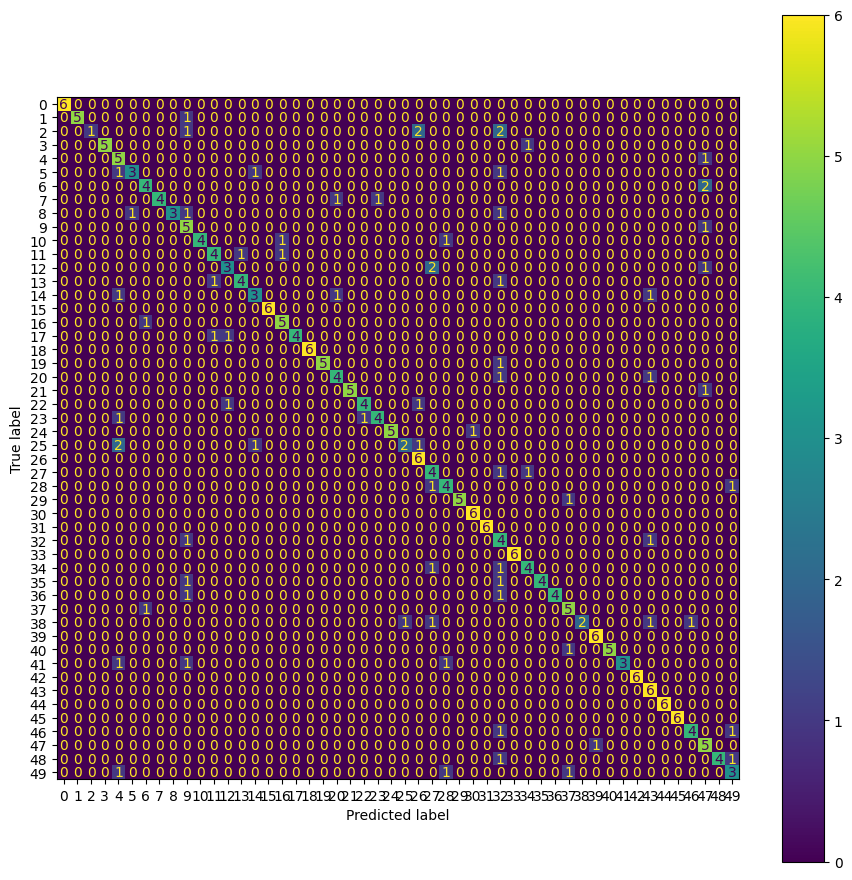

In [94]:
predictions = grid_search_svm_original.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = grid_search_svm_original.best_estimator_.classes_)
fig, ax = plt.subplots(figsize=(11, 11))
disp.plot(ax=ax)

In [96]:
# Approximately 3 out of 50 classes have an accuracy percentage of under 50% on the test set
print(sum(np.diagonal(cm) < 3))

3


Method #4 Logistic Regression

In [105]:
 from sklearn.linear_model import LogisticRegression
 params = {'penalty': ['l2', 'l1', 'elasticnet', 'none']}

In [102]:
logitReg = LogisticRegression(solver='saga')
grid_search_logit_reg_pca = GridSearchCV(logitReg, params, cv=5)
grid_search_logit_reg_pca.fit(X_train_scores_pca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'penalty': ['l2', 'l1', 'elasticnet', 'None']})

In [104]:
print(grid_search_logit_reg_pca.best_score_)
print(grid_search_logit_reg_pca.best_params_)
grid_search_logit_reg_pca.best_estimator_.score(X_test_scores_pca, y_test)

0.7816666666666666
{'penalty': 'l2'}


0.76

In [106]:
#Fitting Logistic Regression on nca
logitReg = LogisticRegression(solver='saga')
grid_search_logit_reg_nca = GridSearchCV(logitReg, params, cv=5)
grid_search_logit_reg_nca.fit(X_train_scores_nca, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [108]:
print(grid_search_logit_reg_nca.best_score_)
print(grid_search_logit_reg_nca.best_params_)
grid_search_logit_reg_nca.best_estimator_.score(X_test_scores_nca, y_test)

0.9208333333333334
{'penalty': 'l2'}


0.7866666666666666

In [110]:
#Fitting Logistic Regression on chi-square
logitReg = LogisticRegression(solver='saga')
grid_search_logit_reg_chi = GridSearchCV(logitReg, params, cv=5)
grid_search_logit_reg_chi.fit(X_train[:, statistically_significant_indices], y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been depre

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [111]:
print(grid_search_logit_reg_chi.best_score_)
print(grid_search_logit_reg_chi.best_params_)
grid_search_logit_reg_chi.best_estimator_.score(X_test[:, statistically_significant_indices], y_test)

0.5766666666666668
{'penalty': 'none'}


0.5333333333333333

In [112]:
#Fitting Logistic Regression on the original, scaled dataset
logitReg = LogisticRegression(solver='saga')
grid_search_logit_reg_original = GridSearchCV(logitReg, params, cv=5)
grid_search_logit_reg_original.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'),
             param_grid={'penalty': ['l2', 'l1', 'elasticnet', 'none']})

In [113]:
print(grid_search_logit_reg_original.best_score_)
print(grid_search_logit_reg_original.best_params_)
grid_search_logit_reg_original.best_estimator_.score(X_test, y_test)

0.7925
{'penalty': 'l2'}


0.8033333333333333

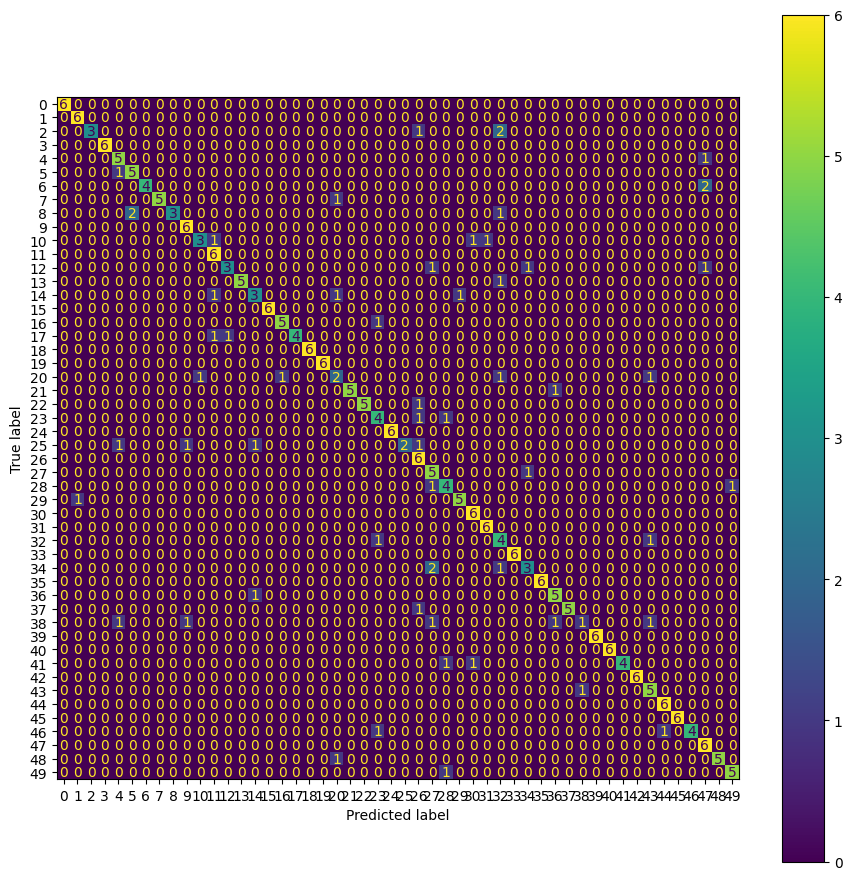

In [114]:
predictions = grid_search_logit_reg_original.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = grid_search_logit_reg_original.best_estimator_.classes_)
fig, ax = plt.subplots(figsize=(11, 11))
disp.plot(ax=ax)

In [115]:
print(sum(np.diagonal(cm) < 3))

3


Method #5 XG-Boost

In [128]:
import xgboost as xgb
params = {
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': [0.02, 0.1],
        }

In [124]:
# First, we fit the xgboost model on the 303 statistically significant variables
clf_chi = xgb.XGBClassifier(n_estimators=50, gamma=0.5, max_depth=3)
grid_search_xg_chi = GridSearchCV(clf_chi, params, refit=True, cv = 5, verbose=2)
grid_search_xg_chi.fit(X_train[:, statistically_significant_indices], y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.6; total time=   2.1s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.6; total time=   3.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.6; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.8; total time=   1.3s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_depth=3, subsample=0.8; total time=   1.4s
[CV] END colsample_bytree=0.6, learning_rate=0.02, max_d

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.5,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [3, 5], 'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [125]:
print(grid_search_xg_chi.best_score_)
print(grid_search_xg_chi.best_params_)
grid_search_xg_chi.best_estimator_.score(X_test[:, statistically_significant_indices], y_test)

0.575
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}


0.5333333333333333

In [132]:
# Now, we fit the xgboost model on the PCA scores
clf_pca = xgb.XGBClassifier(n_estimators=50, gamma=0.5, max_depth=3, n_jobs=-1)
grid_search_xg_pca = GridSearchCV(clf_pca, params, refit=True, cv = 2, verbose=2)
grid_search_xg_pca.fit(X_train_scores_pca, y_train)

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.6; total time=  39.3s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.6; total time=  33.9s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.8; total time=  37.3s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.8; total time=  34.2s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=1.0; total time=  41.0s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=1.0; total time=  39.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.6; total time=  31.9s
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.6; total time=  31.8s
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.8; total time=  33.0s
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.8; total time=  36.1s
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=1.0; total time=  39.1s
[CV] END 

GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.5,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.02, 0.1],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [133]:
print(grid_search_xg_pca.best_score_)
print(grid_search_xg_pca.best_params_)
grid_search_xg_pca.best_estimator_.score(X_test_scores_pca, y_test)

0.29000000000000004
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'subsample': 0.6}


0.38

In [134]:
# Now, we fit the xgboost model on the original data set
clf_original = xgb.XGBClassifier(n_estimators=50, gamma=0.5, max_depth=4, n_jobs=-1)
grid_search_xg_original = GridSearchCV(clf_original, params, refit=True, cv = 3, verbose=2)
grid_search_xg_original.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.6; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.6; total time=  57.6s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.6; total time=  59.9s
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=0.8; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.02, subsample=1.0; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.6; total time= 1.1min
[CV] END colsample_bytree=0.6, learning_rate=0.1, subsample=0.6; total time= 1.1min
[CV] E

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=0.5,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, m...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=50,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.02, 0.1],
                         'subsample': [0.6, 0.8, 1.0]},
             verbose=2)

In [136]:
print(grid_search_xg_original.best_score_)
print(grid_search_xg_original.best_params_)
grid_search_xg_original.best_estimator_.score(X_test, y_test)

0.6558333333333334
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'subsample': 0.6}


0.7333333333333333

Method #6 Neural Networks

In [140]:
import os
import torch
from torch import nn

In [141]:
def encode_one_hot(category):
    listofzeros = [0] * 50
    listofzeros[category] = 1
    return listofzeros

def decode_one_hot(listofzeros):
    category = np.argmax(listofzeros)
    return category

In [156]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10000, 1000),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 50),
            nn.ReLU(),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [159]:
# define loss, optimizier
model = NeuralNetwork().double()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)
criterion = torch.nn.CrossEntropyLoss()

In [160]:
# Train the model
Loss = []
TestSetPerformance = []
epochs = 150
for epoch in range(epochs):
    Loss.append(0)
    TestSetPerformance.append(0)
    print(epoch)
    random_indices = np.random.randint(len(X_train), size=250)
    for i in random_indices:
        x = torch.tensor(X_train[i]).double()
        y = torch.tensor(encode_one_hot(y_train[i]))
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred.float(), y.float())
        Loss[epoch] += loss
        loss.backward()
        optimizer.step()

    test_set_misclassifications = 0
    for i in range(len(X_test)):
      y_pred = model(torch.tensor(X_test[i]).double())
      y_pred = decode_one_hot(y_pred.detach().numpy())
      if y_pred != y_test[i]:
        test_set_misclassifications += 1
    TestSetPerformance[epoch] = 1 - (test_set_misclassifications / len(X_test))

    print(Loss[epoch])
    print(TestSetPerformance[epoch])
    print("**")

0
tensor(977.2270, grad_fn=<AddBackward0>)
0.020000000000000018
**
1
tensor(978.0153, grad_fn=<AddBackward0>)
0.026666666666666616
**
2
tensor(975.3473, grad_fn=<AddBackward0>)
0.030000000000000027
**
3
tensor(974.4461, grad_fn=<AddBackward0>)
0.033333333333333326
**
4
tensor(971.7447, grad_fn=<AddBackward0>)
0.033333333333333326
**
5
tensor(969.1525, grad_fn=<AddBackward0>)
0.030000000000000027
**
6
tensor(961.8836, grad_fn=<AddBackward0>)
0.036666666666666625
**
7
tensor(965.2458, grad_fn=<AddBackward0>)
0.06999999999999995
**
8
tensor(955.6952, grad_fn=<AddBackward0>)
0.040000000000000036
**
9
tensor(942.0505, grad_fn=<AddBackward0>)
0.07333333333333336
**
10
tensor(928.3491, grad_fn=<AddBackward0>)
0.06000000000000005
**
11
tensor(909.1862, grad_fn=<AddBackward0>)
0.08333333333333337
**
12
tensor(907.5287, grad_fn=<AddBackward0>)
0.10333333333333339
**
13
tensor(877.0823, grad_fn=<AddBackward0>)
0.09999999999999998
**
14
tensor(850.9767, grad_fn=<AddBackward0>)
0.14
**
15
tensor(81

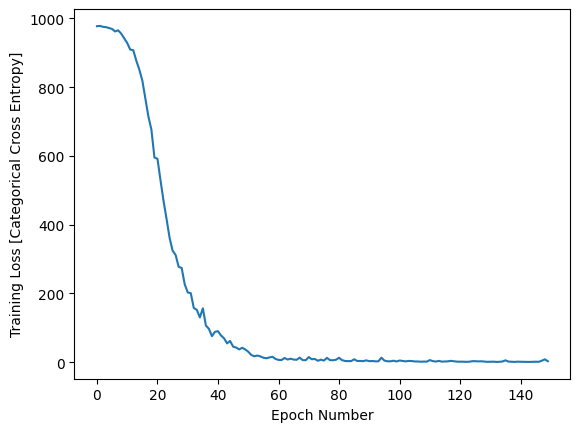

In [161]:
def getItemFromTensorObject(x):
  return x.item()
plt.plot(list(map(getItemFromTensorObject, Loss)))
plt.xlabel('Epoch Number')
plt.ylabel('Training Loss [Categorical Cross Entropy]')
plt.show()

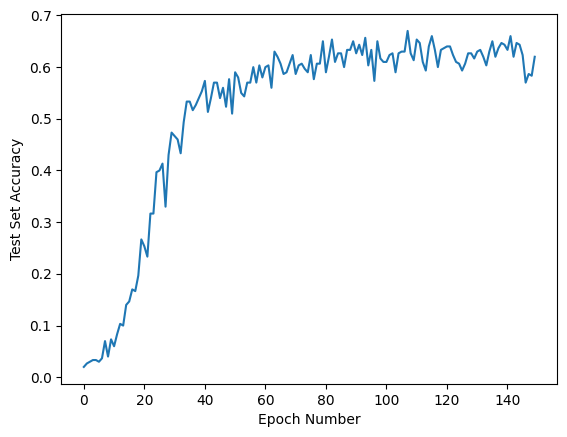

In [162]:
plt.plot(TestSetPerformance)
plt.xlabel('Epoch Number')
plt.ylabel('Test Set Accuracy')
plt.show()